Run the adjusted model and write output netcdf files that are specified in the .ini file. The output files can be specified in the [reportingOptions] section of the .ini file (e.g. setup_05_non-natural.ini).
In the first codecells the required pack

In the first codecells the packages required for the simulation and analysis are imported the pcrglobwb model is imported and initialised as a test to see if the model is working as it should all the output values and modeltimestep information is retrieved to see if the model is initialsed correctly.

In [1]:
#Import docker and set client
import docker
client = docker.from_env()

In [2]:
import os
import time
import datetime
import cftime
from datetime import datetime
from datetime import timedelta

import numpy
import numpy.ma as ma
import pandas as pd
import xarray as xr

import hydrostats.data as hd
import hydrostats.visual as hv
import matplotlib.pyplot as plt

import HydroErr as he
import numpy as np

from ewatercycle.parametersetdb import build_from_urls
from ewatercycle.observation.grdc import get_grdc_data


In [3]:
#Run docker container that contains model
from grpc4bmi.bmi_client_docker import BmiClientDocker
pcrg = BmiClientDocker(image='pcrg-grpc4bmi-setters:latest', image_port=55555, 
                       input_dir="/mnt/home/user35/pcrglob/input", 
                       output_dir="/mnt/home/user35/pcrglob/output")

In [4]:
pcrg.get_component_name()

'pcrglobwb'

In [5]:
#Read the .ini file and initialize the model
%time pcrg.initialize('Aangepast2_pcrglob_05min_Merrimack.ini')

CPU times: user 12.3 ms, sys: 3.65 ms, total: 15.9 ms
Wall time: 35.8 s


In [6]:
#Retrieve the ouput variable names, these variables can be retrieved for each timestep
pcrg.get_output_var_names()

('groundwater_recharge',
 'lake_and_reservoir_storage',
 'domesticWaterConsumptionVolume',
 'land_surface_actual_evaporation',
 'groundwater_storage',
 'snow_melt',
 'totalPotentialMaximumGrossDemand',
 'interception_evaporation',
 'total_groundwater_abstraction',
 'water_body_actual_evaporation',
 'interflow',
 'non_irrigation_gross_demand_volume',
 'livestock_water_withdrawal',
 'land_surface_potential_evaporation',
 'total_groundwater_storage',
 'bare_soil_evaporation',
 'top_water_layer_evaporation',
 'transpiration_from_irrigation',
 'total_thickness_of_active_water_storage',
 'domestic_water_withdrawal',
 'netLqWaterToSoil_at_irrigation_volume',
 'interception_storage',
 'non_irrigation_gross_demand',
 'livestockWaterConsumptionVolume',
 'surface_water_storage',
 'irrigation_gross_demand_volume',
 'upper_soil_storage',
 'desalination_source_abstraction_volume',
 'snow_free_water_evaporation',
 'surface_water_abstraction',
 'industryWaterConsumptionVolume',
 'fossil_groundwater_st

In [7]:
pcrg.get_input_var_names()

('channel_storage', 'upper_soil_saturation_degree')

In [8]:
#Retrieve modeltimestep information
tunit = pcrg.get_time_units()

current_date = cftime.num2date(pcrg.get_current_time(),tunit).date()
start_date = cftime.num2date(pcrg.get_start_time(),tunit).date()
end_date = cftime.num2date(pcrg.get_end_time(),tunit).date()
print(start_date, end_date)

1991-01-01 2012-12-31


### Import fluxnet data for comparison
In the below codecells the fluxnet measured evaporation is imported. Since the fluxnet measures evaporation as latent heat flux the evaporation is rewriten to m/day after which the relevant timeseries is selected.

In [9]:
fnd = pd.read_csv('FLX_US-Ha1_FLUXNET2015_SUBSET_DD_1991-2012_1-4.csv') #Read fluxnet data from exel
fnlhf = fnd['LE_F_MDS'] #Select evaporation measured as latent heat flux from fluxnetdata
fnef = fnlhf / (2.43 * 1000000) * 6772 ** 2 / (3600 * 24) #Rewrite evaporation from latent heat flux to m/day

In [10]:
#The timeseries for the fluxnet measurements goes from 1991 to 2012 for this study the timeseries of interest is from 2003 to 2012
#The original model runs 3650 timesteps including a spin up of one year
#Since the changes to this model will effect the steady state of the groundwaterlevels throughout the model a longer spin up time is required
#To reduce the effect of the changes to the model the spin up is chosen as long as possible, ie all the fluxnet measurements are used.
fne = fnef

### Evolve the model and capture variable discharge

In the following codecells the variables of our choice are defined and arrays are made to save these values over the model run. The startdate, enddate and time per step are also retrieved from the model. The amount of timesteps over which the mode is run is also defined and the last step required to perform the model run is to make an empty dataset in which to store the results. 


In [56]:
variable = 'discharge'
variable2 = 'total_evaporation'
variable3 = 'upper_soil_saturation_degree'
variable4 = 'channel_storage'

In [57]:
vals = pcrg.get_value(variable)
unit = pcrg.get_var_units(variable)
vals2 = pcrg.get_value(variable2) 
unit2 = pcrg.get_var_units(variable2)
vals3 = pcrg.get_value(variable3) 
unit3 = pcrg.get_var_units(variable3)
vals4 = pcrg.get_value(variable4) 
unit4 = pcrg.get_var_units(variable4)
shape = pcrg.get_grid_shape(pcrg.get_var_grid(variable))
grid_id = pcrg.get_var_grid(variable)

lon = pcrg.get_grid_x(grid_id)
lat = pcrg.get_grid_y(grid_id)

In [58]:
tstart = int(pcrg.get_start_time())
tend = int(pcrg.get_end_time())
tstep = int(pcrg.get_time_step())
tstep_nmbr = int((tend - tstart) / tstep)
print(tstart, tend, tstep)

32872 40907 1


In [59]:
tstart = tstart 
# tstep_nmbr = 10
print(tstep_nmbr)

8035


In [60]:
#Create xarray dataset with coordinates and time series
ds = xr.Dataset(coords={'lon': lon,
                        'lat': lat,
                        'time': pd.date_range(start_date, periods=tstep_nmbr)})
ds

<xarray.Dataset>
Dimensions:  (lat: 54, lon: 54, time: 8035)
Coordinates:
  * lon      (lon) float64 40.54 40.63 40.71 40.79 40.88 40.96 41.04 41.13 ...
  * lat      (lat) float64 -73.46 -73.38 -73.29 -73.21 -73.13 -73.04 -72.96 ...
  * time     (time) datetime64[ns] 1991-01-01 1991-01-02 1991-01-03 ...
Data variables:
    *empty*

In [61]:
#Create empty array for faster filling
data_variable = np.zeros(shape=(len(lon), len(lat), 0))
data_variable2 = np.zeros(shape=(len(lon), len(lat), 0)) 
data_variable3 = np.zeros(shape=(len(lon), len(lat), 0)) 
data_variable4 = np.zeros(shape=(len(lon), len(lat), 0))
data_variable5 = np.zeros(shape=(len(lon), len(lat), 0))
data_variable.shape

(54, 54, 0)

In the below codecell the model is run over the defined timesteps. For every timestep the amount of water in the upper soil layer is corrected. Based on the difference between the average land evaporation and the fluxnet measured evaporation a correction factor is calculated. This correction factor is then applied to the model bare soil evaporation to determine the "actual" bare soil evaporation. The difference between the "actual" and model bare soil evaporation is calculated and subsequently added to the upper soil storage. If the upper soil storage is full, the remaining water is redirected and added to the channel storage. If the upper soil storage is empty/becomes empty the required water to fullfil the "actual" bare soil evaporation is taken from the channel storage. After the analysis the new upper soil saturation degree and channel storage are set in the model using pcrg.set_value(...). After the changes to the model all the required information is retrieved and stored. 

In [63]:
#Model run with retrieval of variables for each time step
aflse = np.zeros(int(tstep_nmbr))
aabse = []
acbse = np.zeros(shape=(len(lon), len(lat), 0))
# ssd = pcrg.get_value('')
for idx, i in enumerate(range(int(tstep_nmbr))):
    
    print(f'Time step = {i + 1}')
    pcrg.update_until(tstart + i *tstep)
    
    muss =  1 / pcrg.get_value('upper_soil_saturation_degree') * pcrg.get_value('upper_soil_storage') # maximum storage value of the upper soil layer
#     print(muss)
    lse = pcrg.get_value('land_surface_evaporation')
    mlse = np.nanmean(lse) # Mean land surface evaporation will be compared with the fluxnet measured evaporation
    flse = fne[i] / mlse
    aflse[i] = flse
    
    uss = pcrg.get_value('upper_soil_storage')
    bse = pcrg.get_value('bare_soil_evaporation') # Bare soil evaporation
    abse = bse * flse # "Actual" bare soil evaporation
    aabse.append(abse)
    cbse = abse - bse # correction bare soil evaporation
    cs = pcrg.get_value('channel_storage') # channel storage
#     print(cbse)
#     print(pcrg.get_value('upper_soil_saturation_degree'))
    for j in range(len(uss)):
        if uss[j] + cbse[j] > muss[j]:
            # The correction addition exeeds the maximum storage capacity in the upper soil layer for pixel j. 
            # The additional water is redirected to the channel storage.
            acs = (uss[j] + cbse[j]) - muss[j] # aditional channel storage
            cs[j] = cs[j] + acs #Edit the channel storage in pixel j
            uss[j] = muss[j] # Set the uppers soil storage for pixel j to maximum (the layer is full)

        elif uss[j] + cbse[j] < 0:
            # The correction addition reduces the storage capacity in the uppers soil layer to below zero.
            # A negative storage value is not possible therefore the (remaining) water deficit is taken from the channel storage.
            rfcs = (uss[j] + cbse[j]) # required from channel storage
            cs[j] = cs[j] + rfcs #Edit the channel storage for pixel j
            uss[j] = 0 #Edit the upper soil storage for pixel j to zero (the layer is empty)
           
        else:
            # If the correction additon does not put the value of the soil storage above or below its limits the correction flux is just added.
            uss[j] = uss[j] + cbse[j]
            cussd = uss / muss # Current upper soil saturation degree

    
    cussd = uss / muss # Corrected upper soil saturation degree
    
    pcrg.set_value('upper_soil_saturation_degree', cussd) #After all the pixels have been corrected add the new saturation degrees to the model
    pcrg.set_value('channel_storage', cs) #After all the pixels have been corrected add the new channel storage to the model
    
    vals = pcrg.get_value(variable)
    vals2 = pcrg.get_value(variable2)
    vals3 = pcrg.get_value(variable3)
    vals4 = pcrg.get_value(variable4)
    data = np.reshape(vals, (len(lon), len(lat)))
    data2 = np.reshape(vals2, (len(lon), len(lat)))
    data3 = np.reshape(vals3, (len(lon), len(lat)))
    data4 = np.reshape(vals4, (len(lon), len(lat)))
    data5 = np.reshape(cbse, (len(lon), len(lat)))
    data_variable = np.dstack((data_variable, data))
    data_variable2 = np.dstack((data_variable2, data2))
    data_variable3 = np.dstack((data_variable3, data3))
    data_variable4 = np.dstack((data_variable4, data4))
    acbse = np.dstack((acbse, data5))

Time step = 1
Time step = 2
Time step = 3
Time step = 4
Time step = 5
Time step = 6
Time step = 7
Time step = 8
Time step = 9
Time step = 10
Time step = 11
Time step = 12
Time step = 13
Time step = 14
Time step = 15
Time step = 16
Time step = 17
Time step = 18
Time step = 19
Time step = 20
Time step = 21
Time step = 22
Time step = 23
Time step = 24
Time step = 25
Time step = 26
Time step = 27
Time step = 28
Time step = 29
Time step = 30
Time step = 31
Time step = 32
Time step = 33
Time step = 34
Time step = 35
Time step = 36
Time step = 37
Time step = 38
Time step = 39
Time step = 40
Time step = 41
Time step = 42
Time step = 43
Time step = 44
Time step = 45
Time step = 46
Time step = 47
Time step = 48
Time step = 49
Time step = 50
Time step = 51
Time step = 52
Time step = 53
Time step = 54
Time step = 55
Time step = 56
Time step = 57
Time step = 58
Time step = 59
Time step = 60
Time step = 61
Time step = 62
Time step = 63
Time step = 64
Time step = 65
Time step = 66
Time step = 67
Time

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


Time step = 211
Time step = 212
Time step = 213
Time step = 214
Time step = 215
Time step = 216
Time step = 217
Time step = 218
Time step = 219
Time step = 220
Time step = 221
Time step = 222
Time step = 223
Time step = 224
Time step = 225
Time step = 226
Time step = 227
Time step = 228
Time step = 229
Time step = 230
Time step = 231
Time step = 232
Time step = 233
Time step = 234
Time step = 235
Time step = 236
Time step = 237
Time step = 238
Time step = 239
Time step = 240
Time step = 241
Time step = 242
Time step = 243
Time step = 244
Time step = 245
Time step = 246
Time step = 247
Time step = 248
Time step = 249
Time step = 250
Time step = 251
Time step = 252
Time step = 253
Time step = 254
Time step = 255
Time step = 256
Time step = 257
Time step = 258
Time step = 259
Time step = 260
Time step = 261
Time step = 262
Time step = 263
Time step = 264
Time step = 265
Time step = 266
Time step = 267
Time step = 268
Time step = 269
Time step = 270
Time step = 271
Time step = 272
Time ste

Now the simulation is performd the gained data is stored in a usefull format. It can be than be used to plot a map of the discharge. The location of the red dot marks the location of the GRDC station allong the Merrimack river.

In [69]:
#Append variable data to xarray dataset
ds[variable] = (('lon', 'lat', 'time'), data_variable)
ds[variable2] = (('lon', 'lat', 'time'), data_variable2)
ds[variable3] = (('lon', 'lat', 'time'), data_variable3)
ds[variable4] = (('lon', 'lat', 'time'), data_variable4)
ds['correction_flux'] = (('lon', 'lat', 'time'), acbse)

# als je dit wil opslaan
# ds.to_netcdf('/mnt/home/user35/aangepast2_output_pcrglobwb_evap_discharge_upssatdeg_chanstor_correcflux.nc')

m3.s-1


<xarray.Dataset>
Dimensions:                       (lat: 54, lon: 54, time: 8035)
Coordinates:
  * lon                           (lon) float64 40.54 40.63 40.71 40.79 ...
  * lat                           (lat) float64 -73.46 -73.38 -73.29 -73.21 ...
  * time                          (time) datetime64[ns] 1991-01-01 ...
Data variables:
    discharge                     (lon, lat, time) float64 nan nan nan nan ...
    total_evaporation             (lon, lat, time) float64 nan nan nan nan ...
    upper_soil_saturation_degree  (lon, lat, time) float64 nan nan nan nan ...
    channel_storage               (lon, lat, time) float64 nan nan nan nan ...
    correction_flux               (lon, lat, time) float64 nan nan nan nan ...

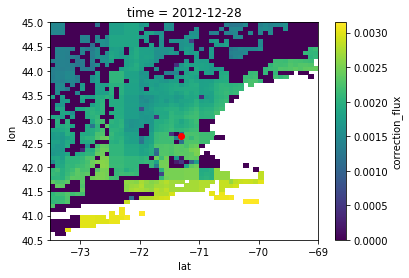

In [124]:
#Plot variable map of time step 100
array = ds['variable'].isel(time= 8032)
array.plot()
plt.plot(-71.2984, 42.6459, 'ro')
print(unit)
ds

Now the simulation is performed and with the means of a plot we have verified that the results are 'logical'. The simulation will now be compared to the observations of the GRDC station. For this comparison the discharge as calculated by the model at the location of the GRDC station is saved to a different array. The GRDC data is imported as another array and both arrays are than used to determine the NSE, KGE and plot a hydrograph with the help of the hydrostats package.

In [25]:
# Select timeseries based on lat lon of GRDC station
timeseries = ds[variable].sel(lat=-71.2984, lon=42.6459, method= 'nearest')

sim = timeseries.to_dataframe()

In [29]:
station_id = '4147380' 
observations = get_grdc_data(station_id, str(start_date), str(end_date))
obs_df = observations.to_dataframe()
sim["observation"] = obs_df["streamflow"]
# sim = sim.drop(columns=['lat', 'lon'])
simoly = sim[-3653:-368]

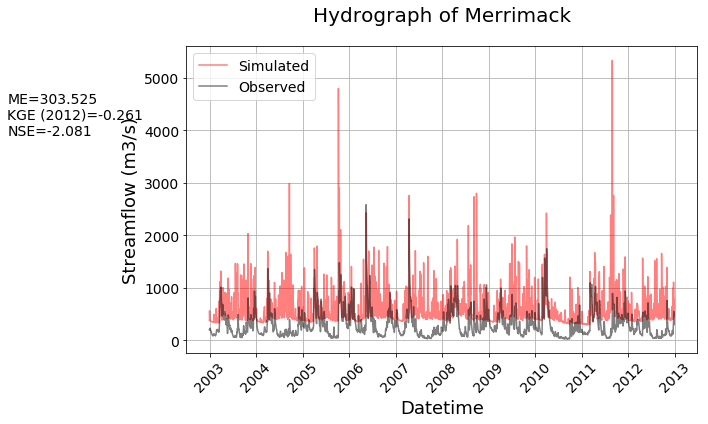

In [30]:
hv.plot(simoly[['discharge', 'observation']],
title='Hydrograph of Merrimack',
linestyles=['r-', 'k-'],
legend=('Simulated', 'Observed'),
labels=['Datetime', 'Streamflow (m3/s)'],
metrics=['ME', 'KGE (2012)', 'NSE'],
grid=True)
plt.show()

To get an idea of the size of the effect of the changes in the model in the following cells the sum of the correction flux for all pixel is plotted over time. In the first graph the sum of the correction flux is plotted per day, in the second graph the cumulant sum of the correction flux is plotted per day.

In [72]:
cfpt = np.zeros(len(ds['time']))
for i in range(len(cfpt)):
    cfpt[i] = ds['correction_flux'].isel(time = i).sum()
    
display(cfpt[-3650:])

array([0.00339263, 0.0531535 , 0.10092041, ..., 2.38697382, 0.11784083,
       3.18259086])

23.661763858478107

-1.454202522025788

3.450415740982474

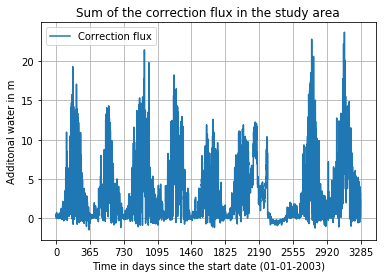

In [117]:
cfptnsu = cfpt[-3285:]
plt.plot(cfptnsu, label=(f'Correction flux'))
plt.xlabel(f'Time in days since the start date (01-01-2003)')
plt.ylabel(f'Additonal water in m')
plt.xticks(np.linspace(0, 3285, 10))
plt.legend(loc='best')
plt.grid()
plt.title(f'Sum of the correction flux in the study area')
display(cfptnsu.max(), cfptnsu.min(), cfptnsu.mean())

In [101]:
ccfptnsu = np.zeros(len(cfptnsu))
ccfptnsu[0] = cfptnsu[0]
for i in range(1, len(cfptnsu) - 1):
    ccfptnsu[i] = ccfptnsu[i - 1] + cfptnsu[i]  

11331.433118267316

0.0

5498.557500455587

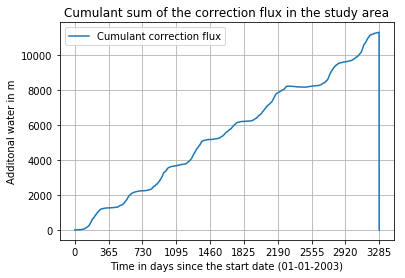

In [116]:
plt.plot(ccfptnsu, label=(f'Cumulant correction flux'))
plt.xlabel(f'Time in days since the start date (01-01-2003)')
plt.ylabel(f'Additonal water in m')
plt.xticks(np.linspace(0, 3285, 10))
plt.legend(loc='best')
plt.grid()
plt.title(f'Cumulant sum of the correction flux in the study area')
display(ccfptnsu.max(), ccfptnsu.min(), ccfptnsu.mean())

Further more two graphs are plotted the first graph showing the upper soil saturation degree over time for the pixel at -72, 43. The second graph shows the channel storage over time for pixel -72, 43. 

Text(0.5,1,'Upper soil saturation degree over time for pixel -72, 43')

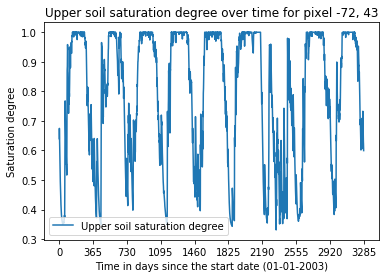

In [115]:
pussd = ds[variable3].sel(lat=-72, lon=43, method= 'nearest')[-3285:]
pcs = ds[variable4].sel(lat=-72, lon=43, method= 'nearest')[-3285:]
# plt.figure(figsize=(20,10))
plt.plot(pussd, label=f'Upper soil saturation degree')
plt.xticks(np.linspace(0, 3285, 10))
plt.xlabel(f'Time in days since the start date (01-01-2003)')
plt.ylabel(f'Saturation degree')
# plt.plot(pcs, label=f'Channel storage', )
plt.legend(loc='best')
plt.title('Upper soil saturation degree over time for pixel -72, 43')

In [1]:
# plt.figure(figsize=(20,10))
plt.plot(pcs, label=f'Channel storage')
plt.xticks(np.linspace(0, 3285, 10))
plt.xlabel(f'Time in days since the start date (01-01-2003)')
plt.ylabel(f'Channel storage in m')
plt.title('Channel storage over time for pixel -72, 43')
plt.legend(loc='best')

NameError: name 'plt' is not defined

With the simulations and analysis performed the model is closed and the pcrg instance is deleted

In [125]:
#Write output files and close model
pcrg.finalize()

In [126]:
#Remove pcrg
del pcrg